<a href="https://colab.research.google.com/github/Yjaywang/test/blob/main/crystal_grain_size_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

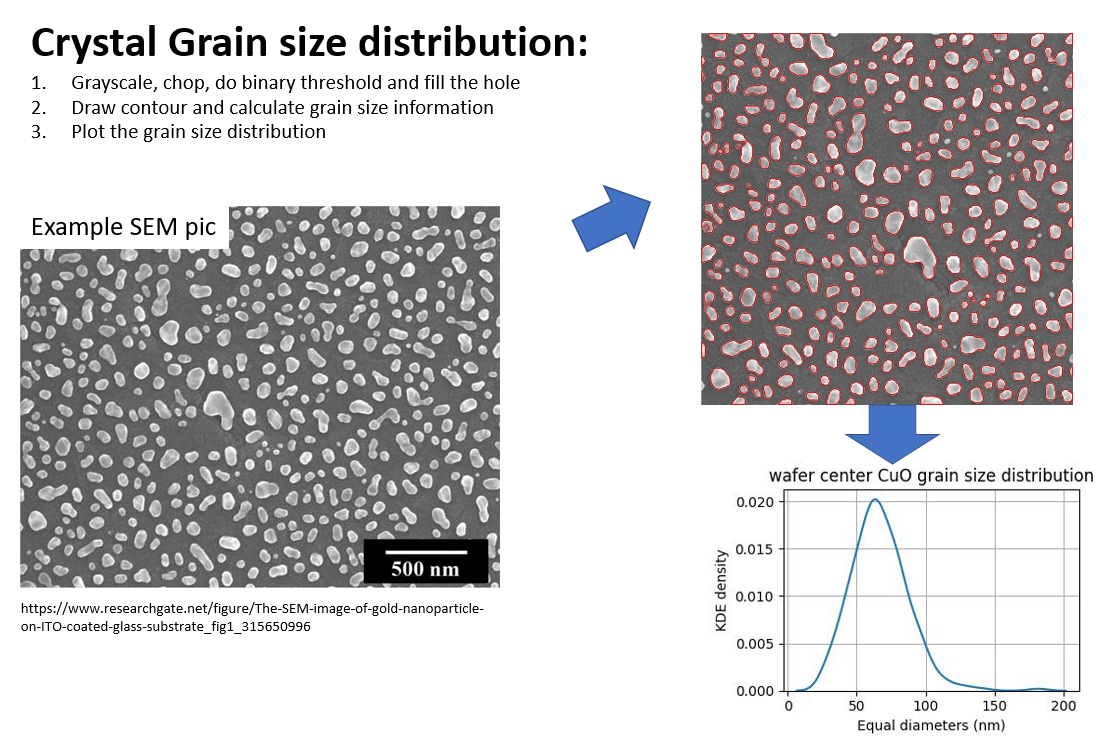

In [25]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import seaborn as sns
import csv
import seaborn as sns
import requests

In [23]:
def haze_pretreatment(haze): #二分化，CONTOUR前處理
    def modify_contrast_and_brightness2(img, brightness=0, contrast=100):  #條亮度對比
        brightness = 0
        contrast = 100
        B = brightness / 255.0
        C = contrast /255.0
        K = math.tan((45+44*C)/180*math.pi)
        
        img = (img-127.5*(1-B))*K+127.5*(1+B)
        img=np.clip(img, 0, 255).astype(np.uint8) #所有質介於0-255，超過255就=255，小於0就=0
        return img

    haze =cv2.cvtColor(haze, cv2.COLOR_BGR2GRAY)#轉灰階
    haze =modify_contrast_and_brightness2(haze)#條對比亮度
    #cv2.imshow('haze', haze)   #看調得怎樣
    haze =cv2.GaussianBlur(haze,(5,5),0)
    dkernel =np.ones((3,3),np.uint8)
    ekernel =np.ones((3,3),np.uint8)
    haze =cv2.dilate(haze, dkernel, iterations =1)
    haze =cv2.erode(haze, ekernel, iterations =1)
    #plt.hist(haze.ravel(), 256, [0,256])  #找適合的threshold
    #plt.show()
    #plt.hist(haze.ravel(), 256, [0,256])  #找適合的threshold，存檔用
    #plt.savefig(th_hist_img_name)

    ret, thresh1 =cv2.threshold(haze, 150, 255, cv2.THRESH_BINARY)#設定THRESHOLD二值化
    th_fill =ndimage.binary_fill_holes(thresh1).astype(int)*255 #填洞讓晶體不中空
    th_fill =th_fill.astype(np.uint8)
    
    #cv2.imshow('th_fill', th_fill) 
    #cv2.imwrite(haze_img_name, th_fill, [cv2.IMWRITE_JPEG_QUALITY, 90]) #存HAZE圖
    return th_fill

def recogPicfun(thresh1, img):
    cnt, h=cv2.findContours(thresh1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt_new =[]
    Areas =[]
    Circularities =[]
    Eq_diameters =[]

    for i in cnt:
        if cv2.contourArea(i) <=20: #過濾掉20 Px^2殘渣
            continue
        cnt_new.append(i)

        #面積(px^2)
        area =cv2.contourArea(i)
        Areas.append(area)

        #圓完整性
        arc =cv2.arcLength(i, True)
        circularity = 4*np.pi * area / (arc*arc)
        Circularities.append(circularity)

        #等效半徑(px)
        eq_diameter = np.sqrt(4*area/np.pi)
        Eq_diameters.append(eq_diameter)

    #print('img shape, ', img.shape) #看IMAGE SHAPE
    print('CuO coverage: ', sum(Areas)/(np.array(img.shape)[0]*np.array(img.shape[1]))) #看CuO覆蓋比率

    #畫CONTOURS
    img=cv2.drawContours(img,cnt_new, -1, (0,0,255),1)
    #cv2.imshow('contour', img) #看CONTOUR圖
    cv2.imwrite('contour.jpg', img, [cv2.IMWRITE_JPEG_OPTIMIZE, 90]) #存CONTOUR圖
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    #把PX轉成實際單位，LIST轉ARRAY做計算
    nd_Areas= np.array(Areas)/((500/97)*(500/97))  #nm^2
    nd_Eq_diameters = np.array(Eq_diameters)*500/97  #nm
    #再把ARRAY轉回LIST，方便作圖
    Areas =nd_Areas.tolist()
    Eq_diameters =nd_Eq_diameters.tolist()
    Area_min, Area_max = min(Areas), max(Areas)
    Circularities_min, Circularities_max = min(Circularities), max(Circularities)
    Eq_diameters_min, Eq_diameters_max = min(Eq_diameters), max(Eq_diameters)

    print('average Areas (nm^2): ', np.average(Areas))
    print('average Circularities: ', np.average(Circularities))
    print('average Eq_diameters (nm): ', np.average(Eq_diameters))
    print('median Areas (nm^2): ', np.median(Areas))
    print('median Circularities: ', np.median(Circularities))
    print('median Eq_diameters (nm): ', np.median(Eq_diameters))

    with open('data.csv', 'w', newline= '') as file:
        write =csv.writer(file)
        write.writerow(Areas)
        write.writerow(Circularities)
        write.writerow(Eq_diameters)

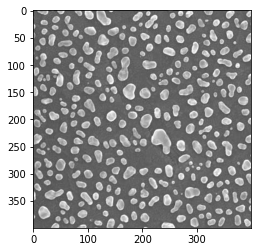

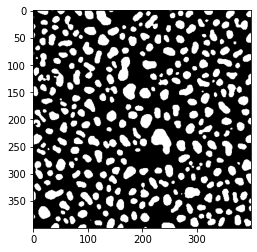

CuO coverage:  0.258740625


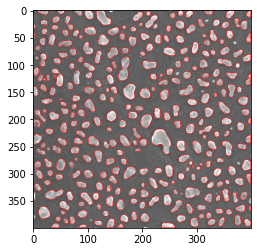

average Areas (nm^2):  5.466926126315789
average Circularities:  0.7715985931105748
average Eq_diameters (nm):  66.96031421100803
median Areas (nm^2):  4.7044999999999995
median Circularities:  0.8154556269620676
median Eq_diameters (nm):  65.0291887118598


In [29]:

img_path ='./The-SEM-image-of-gold-nanoparticle-on-ITO-coated-glass-substrate.png' #https://www.researchgate.net/profile/Elham-Rezasoltani/publication/315650996/figure/fig1/AS:642913490984963@1530293929402/The-SEM-image-of-gold-nanoparticle-on-ITO-coated-glass-substrate.png
img=cv2.imread(img_path)
img=img[:400,:400]
#cv2.imshow('test',img)

haze=haze_pretreatment(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #notebook display pic
plt.show()
plt.imshow(cv2.cvtColor(haze, cv2.COLOR_BGR2RGB))
plt.show()
recogPicfun(haze, img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


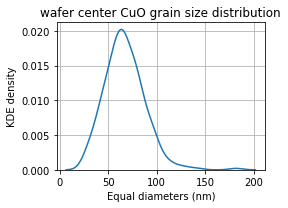

In [17]:
with open('./data.csv') as file1:
    test1 =csv.reader(file1)
    WC1 =list(test1)


fig_WC =plt.figure(figsize=(4,3))
plt.title("wafer center CuO grain size distribution")
sns.distplot(WC1[2], hist=False, label='condition_1') #WC1密度圖
plt.ylabel('KDE density') # y label
plt.xlabel('Equal diameters (nm)')
plt.grid(True)
plt.tight_layout()
fig_WC.savefig(r'plot_density.jpg')